# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb


# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)

In [10]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [11]:
realized_pnl_time=pd.DataFrame(dic).fillna(0).fillna(method='ffill')


In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total
Total,2184.9350,2026.8678,1.0000,-131.8862,-158.0672,-289.9534
JASMYUSDT,387.4585,247.6706,0.1222,0.0000,-139.7879,-139.7879
ETHUSDT,250.7473,169.4927,0.0836,0.0000,-81.2546,-81.2546
BBUSDT,60.1761,37.8689,0.0187,-39.7331,-22.3072,-62.0403
BTCUSDT,601.0216,555.2271,0.2739,3.5371,-45.7945,-42.2574
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
SOLUSDT,281.2005,262.2820,0.1294,0.0000,-18.9185,-18.9185
BNBUSDT,1.1421,0.9789,0.0005,-10.6060,-0.1632,-10.7692
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,77.3709,0.0382,-10.7239,0.5020,-10.2219


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

In [20]:
positions

,BBUSDT,BNBUSDT,BTCUSDT,ETHUSDT,JASMYUSDT,OMUSDT,PEPEUSDT,SOLUSDT,TRXUSDT
2024-09-13,38.264689,0.022323,615.434659,169.124532,270.058157,234.487353,0.000002,248.907400,289.281764
2024-09-14,38.730337,0.022198,610.297696,167.640734,262.510345,228.287067,0.000002,245.541367,286.369532
2024-09-15,36.506864,0.022202,601.538601,160.589920,252.276024,223.210322,0.000002,235.210510,289.281764
2024-09-16,37.729192,0.021412,592.199860,159.174072,245.495786,220.235016,0.000002,235.389554,289.087615
2024-09-17,40.523085,0.021914,613.562761,162.371864,252.531882,218.508091,0.000002,235.514885,291.223252
2024-09-18,41.629001,0.022447,546.624084,164.656497,260.335552,322.801671,0.000002,240.528126,290.446657
2024-09-19,41.535871,0.022748,557.138811,170.928663,270.058157,314.231467,0.000002,255.836415,294.135485
2024-09-20,41.174993,0.022828,559.378589,177.598127,269.290583,326.876031,0.000002,262.586385,295.106229
2024-09-21,44.050375,0.023615,560.687708,181.134281,272.488809,330.107419,0.000002,267.510104,295.106229
2024-09-22,41.861825,0.023619,562.721617,178.957119,266.476145,321.087630,0.000002,258.951786,294.523783


In [21]:
positions=positions.sort_index()

In [22]:
positions.index=pd.to_datetime(positions.index)

In [23]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [24]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [25]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [27]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [28]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [29]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [30]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [31]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

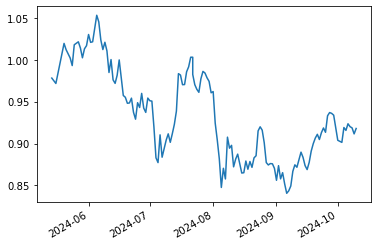

In [32]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [33]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [34]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [35]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT',
       'XRPUSDT'],
      dtype='object')

In [36]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9317
OMUSDT,0.0249
TRXUSDT,0.0192
BNBUSDT,0.0168
PEPEUSDT,0.0053
SUIUSDT,0.0021
BONKUSDT,0.0000
LDOUSDT,0.0000
RUNEUSDT,0.0000
CFXUSDT,0.0000


In [38]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.496883
BTCUSDT,0.400000
PEPEUSDT,0.071943
SUIUSDT,0.020612
BNBUSDT,0.010562


In [39]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [40]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.710242
OMUSDT,0.289758


## Real Portfolio vs Optimal

In [41]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,675.976670,0.333508,0.289758,0.043750
BTCUSDT,555.227131,0.273934,0.000000,0.000000
SOLUSDT,262.282010,0.129403,0.000000,0.000000
JASMYUSDT,247.670579,0.122194,0.000000,0.000000
ETHUSDT,169.492708,0.083623,0.000000,0.000000
TRXUSDT,77.370903,0.038173,0.710242,-0.672069
BBUSDT,37.868887,0.018683,0.000000,0.000000
BNBUSDT,0.978920,0.000483,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [42]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,675.976670,0.333508,0.496883,-0.163375
BTCUSDT,555.227131,0.273934,0.400000,-0.126066
SOLUSDT,262.282010,0.129403,0.000000,0.000000
JASMYUSDT,247.670579,0.122194,0.000000,0.000000
ETHUSDT,169.492708,0.083623,0.000000,0.000000
TRXUSDT,77.370903,0.038173,0.000000,0.000000
BBUSDT,37.868887,0.018683,0.000000,0.000000
BNBUSDT,0.978920,0.000483,0.010562,-0.010079
PEPEUSDT,0.000002,0.000000,0.071943,-0.071943
SUIUSDT,0.000000,0.000000,0.020612,0.000000


# Risk Reward Analysis

In [43]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [44]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

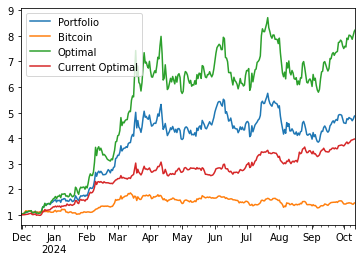

In [45]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [46]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

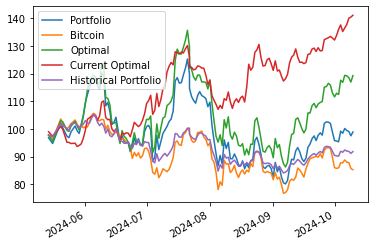

In [47]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [48]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-01,95.795078,85.969490,111.593228,132.151346,90.386098
2024-10-02,95.619373,85.747939,112.913356,133.819575,90.261509
2024-10-03,95.354824,85.894047,112.479491,136.026287,90.135937
2024-10-04,99.198928,87.758707,117.616223,137.626524,91.907783
2024-10-05,98.435596,87.719120,116.838026,135.248830,91.567253
2024-10-06,100.148741,88.789524,119.377516,136.477734,92.355012
2024-10-07,99.427579,87.943245,119.204722,137.770662,92.014237
2024-10-08,99.082006,87.853439,118.505942,140.047018,91.863073
2024-10-09,97.509341,85.671996,116.971906,140.469541,91.148267
2024-10-10,98.883417,85.233402,119.275974,141.120964,91.791854


## Volatilities

In [49]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.734593
dtype: float64

In [50]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.535205
dtype: float64

In [51]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.614303
Bitcoin            0.436864
Optimal            0.735723
Current Optimal    0.440813
dtype: float64

In [52]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20163635233338806

## Risk Contribution

In [53]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.012479,0.010562,0.001741,0.002854,0.000049,0.002805
BTCUSDT,0.190290,0.400000,0.044606,0.147891,0.056414,0.091477
OMUSDT,11.835202,0.496883,0.931895,0.784098,0.691253,0.092845
PEPEUSDT,0.174872,0.071943,0.018651,0.056918,0.015545,0.041373
SUIUSDT,0.020496,0.020612,0.003106,0.008240,0.000716,0.007524


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.198027,0.289758,0.357097,0.553615,0.493341,0.060273
TRXUSDT,0.167945,0.710242,0.642903,0.446385,0.386112,0.060273


In [55]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.227807,0.333333,0.486793,0.430659,0.261365,0.169295
BTCUSDT,-0.013869,0.272727,0.224561,0.172393,0.042740,0.129653
SOLUSDT,-0.016520,0.131313,0.099584,0.129307,0.025694,0.103612
JASMYUSDT,-0.023154,0.121212,0.085066,0.166618,0.046284,0.120334
ETHUSDT,-0.019261,0.080808,0.053393,0.061511,0.006470,0.055042
TRXUSDT,0.009554,0.040404,0.043339,0.006050,0.000500,0.005550
BBUSDT,-0.011828,0.020202,0.007264,0.033460,0.002717,0.030743


# Value At Risk

## Historical

In [56]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06076757422203706, -0.0874214092051344)

In [57]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04854024341802648, -0.06859964078039954)

In [58]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [59]:
var=historical_var.iloc[row]
var

OMUSDT       0.013326
BTCUSDT     -0.020150
SOLUSDT     -0.008378
JASMYUSDT   -0.020068
ETHUSDT     -0.008529
TRXUSDT     -0.001597
BBUSDT      -0.002595
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047991
Name: 2024-08-05 00:00:00, dtype: float64

In [60]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.025573
BTCUSDT     -0.012467
SOLUSDT     -0.009478
JASMYUSDT   -0.011235
ETHUSDT     -0.004990
TRXUSDT     -0.000675
BBUSDT      -0.001892
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.066310
dtype: float64

## Parametric

In [61]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07623265873266451, -0.0977091913324584)

In [62]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05545578908587747, -0.07107898893158635)

## Multivariate

In [63]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06837740956779306, -0.08819927971923439)

In [64]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05454329016857925, -0.06778128339551688)

In [65]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.022113
BTCUSDT     -0.009744
SOLUSDT     -0.007034
JASMYUSDT   -0.009020
ETHUSDT     -0.003832
TRXUSDT     -0.000286
BBUSDT      -0.001801
Portfolio   -0.053829
dtype: float64

## Copulas

### Gaussian Copula

In [66]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06968761355851309, -0.08900484691045144)

In [67]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05362801928114877, -0.06760901588589778)

In [68]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021805
BTCUSDT     -0.009536
SOLUSDT     -0.007050
JASMYUSDT   -0.009570
ETHUSDT     -0.003772
TRXUSDT     -0.000314
BBUSDT      -0.001891
Portfolio   -0.053938
dtype: float64

### Student Copula

In [69]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06632112626466832, -0.08763505013038701)

In [70]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055191849265623476, -0.07053623324736054)

In [71]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.022256
BTCUSDT     -0.009720
SOLUSDT     -0.007359
JASMYUSDT   -0.009642
ETHUSDT     -0.003399
TRXUSDT     -0.000392
BBUSDT      -0.002012
Portfolio   -0.054780
dtype: float64

### Gumbel Copula

In [72]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1432121030456464, -0.20151019606987744)

In [73]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07279967751599639, -0.10045888623301169)

In [74]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.048102
BTCUSDT     -0.007432
SOLUSDT     -0.003967
JASMYUSDT   -0.010599
ETHUSDT     -0.001198
TRXUSDT      0.000084
BBUSDT      -0.000993
Portfolio   -0.072206
dtype: float64

### Monte Carlo

In [75]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [76]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07769062477007718, -0.09655242275833302)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.057084279040730955, -0.07152475639768605)

In [78]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.024137
BTCUSDT     -0.009868
SOLUSDT     -0.007255
JASMYUSDT   -0.009308
ETHUSDT     -0.003480
TRXUSDT     -0.000313
BBUSDT      -0.002019
Portfolio   -0.056380
dtype: float64

## VaR Violation

In [79]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062113,-0.111040,-0.092975,-0.025260
2024-01-15,-0.062113,-0.111038,-0.097820,0.016926
2024-01-16,-0.062113,-0.111590,-0.089990,0.060954
2024-01-17,-0.062113,-0.113963,-0.098519,-0.035646
2024-01-18,-0.062113,-0.116267,-0.098978,-0.036999
...,...,...,...,...
2024-10-08,-0.022940,-0.057446,-0.046781,-0.005862
2024-10-09,-0.022940,-0.052418,-0.045045,-0.012945
2024-10-10,-0.022940,-0.050185,-0.043851,0.019698
2024-10-11,-0.022940,-0.050481,-0.041321,0.020042


In [80]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031674,-0.084627,-0.078972,-0.017010
2024-05-29,-0.029583,-0.081787,-0.073557,-0.009853
2024-05-30,-0.029583,-0.070728,-0.066200,0.034057
2024-05-31,-0.029583,-0.070106,-0.061714,0.029358
2024-06-01,-0.029583,-0.071904,-0.063399,0.044376
...,...,...,...,...
2024-10-08,-0.031172,-0.048280,-0.046869,-0.003476
2024-10-09,-0.031172,-0.049019,-0.049757,-0.015872
2024-10-10,-0.031172,-0.049486,-0.049142,0.014092
2024-10-11,-0.031172,-0.043844,-0.043908,0.022782


<AxesSubplot:>

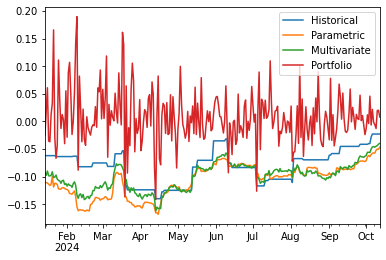

In [81]:
var_data.plot()

<AxesSubplot:>

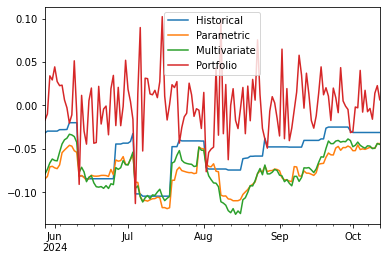

In [82]:
current_var_data.plot()

In [83]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021978,0.007326,0.010989
Kupiec Stat,5.659704,16.133284,12.640704
P-value,0.017359,0.000059,0.000377


In [84]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057971,0.021739,0.021739
Kupiec Stat,0.175978,2.91743,2.91743
P-value,0.674853,0.087627,0.087627


## Principal Component Analysis

### Historical PCA

In [85]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78851533, 0.06775448, 0.05553699, 0.04540684, 0.04278637])

In [86]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.014927
ADAUSDT      0.015208
ALGOUSDT     0.016775
APTUSDT      0.016074
ARBUSDT      0.016549
               ...   
WBETHUSDT    0.012713
WBTCUSDT     0.010552
WLDUSDT      0.023066
XLMUSDT      0.010100
XRPUSDT      0.009732
Name: PC1, Length: 61, dtype: float64

<AxesSubplot:>

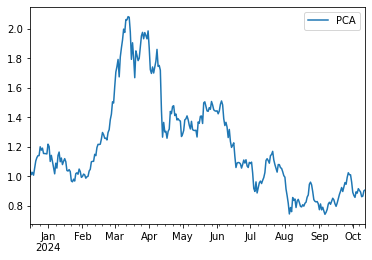

In [87]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

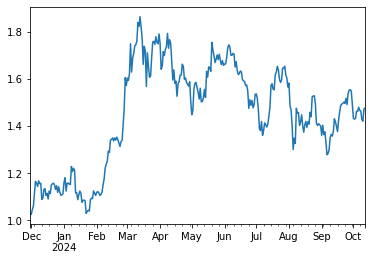

In [88]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [89]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.343497
ALGOUSDT     0.350472
ETHUSDT      0.359411
WBETHUSDT    0.359527
               ...   
BONKUSDT     0.968899
PEPEUSDT     1.005042
FLOKIUSDT    1.010558
WLDUSDT      1.054122
OMUSDT       1.321720
Length: 62, dtype: float64

<AxesSubplot:>

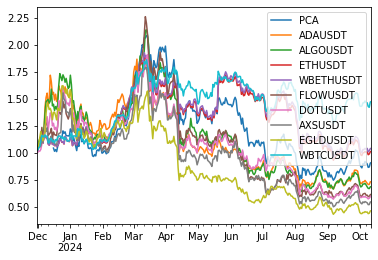

In [90]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

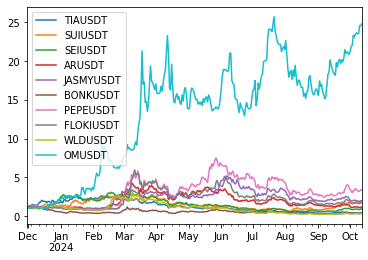

In [91]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [92]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.673006  , 0.13735421, 0.08804422, 0.06952902, 0.03206655])

In [93]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095558
BTCUSDT      0.064844
SOLUSDT      0.104843
JASMYUSDT    0.155059
ETHUSDT      0.086670
TRXUSDT      0.014661
BBUSDT       0.242866
BNBUSDT      0.068132
PEPEUSDT     0.167368
Name: PC1, dtype: float64

<AxesSubplot:>

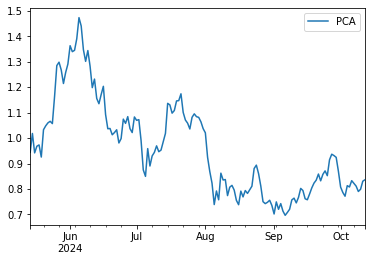

In [94]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

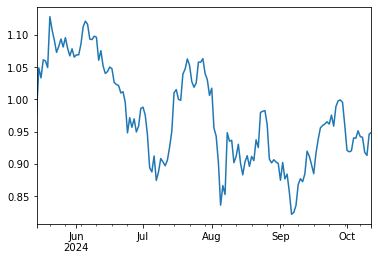

In [95]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [96]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.337580
SOLUSDT      0.345785
BTCUSDT      0.371894
BNBUSDT      0.375996
JASMYUSDT    0.428653
PEPEUSDT     0.479719
OMUSDT       0.558565
TRXUSDT      0.559778
BBUSDT       0.632629
dtype: float64

<AxesSubplot:>

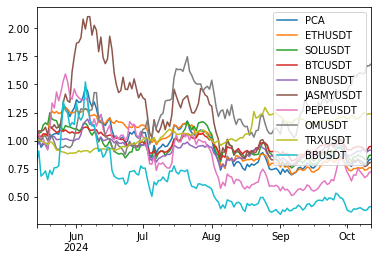

In [97]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [98]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.949916
BBUSDT       1.663050
JASMYUSDT    1.297732
SOLUSDT      1.170370
BTCUSDT      1.000000
OMUSDT       0.968035
ETHUSDT      0.955838
BNBUSDT      0.677345
TRXUSDT      0.277090
Name: BTCUSDT, dtype: float64

In [99]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.302795
PEPEUSDT     2.132533
JASMYUSDT    1.728286
SOLUSDT      1.294008
BTCUSDT      1.000000
ETHUSDT      0.972067
BNBUSDT      0.886076
OMUSDT       0.222771
TRXUSDT      0.145490
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [100]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
